In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial import distance
from scipy.optimize import curve_fit
from scipy.optimize import minimize,differential_evolution
from mpl_toolkits.axes_grid1 import make_axes_locatable
import string
import pandas as pd

In [3]:
## Model structure
Mt = 40
Nt = 20

Ma = 20
Na = 3

## Model parameters

# Unisensory receptive fields
phit_0 = 1
sigmat_phi = 0.5
phia_0 = 1
sigmaa_phi = 10

# External stimuli
it_0 = 2.5
sigmat_i = 0.3
sigmat_v = 0.1
xt_0 = 10 
yt_0 = 5

ia_0 = 3.6
sigmaa_i = 0.3
sigmaa_v = 0.4
ya_0 = 5
xa_0 = 100

tt_0 = 0
ta_0 = 0

In [4]:
## Receptive fields

# Tactile RF centres
xt = np.arange(1,Mt+1)*0.5 
yt = np.arange(1,Nt+1)*0.5

# Auditory RF centres
xa = (np.arange(1,Ma+1)*10)-5
ya = (np.arange(1,Na+1)*10)-15
              
def phit(x,y):
    phi = np.zeros((Mt,Nt))
    for i in range(Mt):
        for j in range(Nt):
            phi[i][j] = phit_0*np.exp(-((np.square(xt[i]-x)+np.square(yt[j]-y))/(2*np.square(sigmat_phi))))
    return phi

def phia(x,y):
    phi = np.zeros((Ma,Na))
    for i in range(Ma):
        for j in range(Na):
            phi[i][j] = phia_0*np.exp(-((np.square(xa[i]-x)+np.square(ya[j]-y))/(2*np.square(sigmaa_phi))))
    return phi

# Calculation
dif = 0.2
xt_i = np.arange(0,20+dif,dif)
yt_n = np.arange(0,10+dif,dif)

phi_t = np.zeros((Mt,Nt,len(xt_i),len(yt_n)))        
for k in range(len(xt_i)):
    for l in range(len(yt_n)):
        phi_t[:,:,k,l] = phit(xt_i[k],yt_n[l])
        
xa_i = np.arange(0,200+dif,dif)
ya_n = np.arange(0,30+dif,dif)

phi_a = np.zeros((Ma,Na,len(xa_i),len(ya_n)))        
for k in range(len(xa_i)):
    for l in range(len(ya_n)):
        phi_a[:,:,k,l] = phia(xa_i[k],ya_n[l])
        

## External stimulus
def stimt(x,y,t):
    if t<tt_0: 
        I = 0
    else: 
        #v = np.random.normal(0, sigmat_v)
        #I = (it_0+sigmat_v*v)*np.exp(- (np.square(xt_0-x)+np.square(yt_0-y))/(2*np.square(sigmat_i)))
        I = (it_0)*np.exp(- (np.square(xt_0-x)+np.square(yt_0-y))/(2*np.square(sigmat_i)))
    return I 

def stima(x,y,t,xa_0):
    if t<ta_0: 
        I = 0
    else: 
        #v = np.random.normal(0, sigmaa_v)
        #I = (ia_0+sigmaa_v*v)*np.exp(- (np.square(xa_0-x)+np.square(ya_0-y))/(2*np.square(sigmaa_i)))
        I = (ia_0)*np.exp(- (np.square(xa_0-x)+np.square(ya_0-y))/(2*np.square(sigmaa_i)))
    return I 

## Unisensory input
def PHIt(t):

        PHI = np.zeros((Mt,Nt,len(xt_i),len(yt_n)))        
        
        for k in range(len(xt_i)):
            for l in range(len(yt_n)):
                PHI[:,:,k,l] = np.multiply(phi_t[:,:,k,l],stimt(xt_i[k],yt_n[l],t))
        PHI = np.sum(PHI,axis=3)
        PHI = np.sum(PHI,axis=2)
        
        return PHI
    
def PHIa(t,xa_0):

        PHI = np.zeros((Ma,Na,len(xa_i),len(ya_n)))        
        
        for k in range(len(xa_i)):
            for l in range(len(ya_n)):
                PHI[:,:,k,l] = np.multiply(phi_a[:,:,k,l],stima(xa_i[k],ya_n[l],t,xa_0))
        PHI = np.sum(PHI,axis=3)
        PHI = np.sum(PHI,axis=2)
        
        return PHI
        

In [5]:
## Lateral connections in unisensory areas

def Lw(Lt_ex,Lt_in,sigmat_ex,sigmat_in,La_ex,La_in,sigmaa_ex,sigmaa_in):
    # Tactile Connections
    Lt = np.zeros((Mt*Nt,Mt*Nt))

    for i in range(Mt*Nt):
        for j in range(Mt*Nt):
            if i==j: 
                Lt[i,j] = 0
            else:
                Dtx = xt[np.floor_divide(i,Nt)] - xt[np.floor_divide(j,Nt)]
                Dty = yt[np.remainder(i,Nt)] - yt[np.remainder(j,Nt)]
                Lt[i,j] = Lt_ex*np.exp(- (np.square(Dtx)+np.square(Dty))/(2*np.square(sigmat_ex)))-Lt_in*np.exp(- (np.square(Dtx)+np.square(Dty))/(2*np.square(sigmat_in)))

    # Auditory Connections
    La = np.zeros((Ma*Na,Ma*Na))

    for i in range(Ma*Na):
        for j in range(Ma*Na):
            if i==j: 
                La[i,j] = 0
            else:
                Dax = xa[np.floor_divide(i,Na)] - xa[np.floor_divide(j,Na)]
                Day = ya[np.remainder(i,Na)] - ya[np.remainder(j,Na)] #before was remainder-1
                La[i,j] = La_ex*np.exp(- (np.square(Dax)+np.square(Day))/(2*np.square(sigmaa_ex)))-La_in*np.exp(- (np.square(Dax)+np.square(Day))/(2*np.square(sigmaa_in)))

    return Lt,La            
                
# Lateral inputs
def LIt(z):
    # z is a matrix of MtxNt dimensions
    LI = np.zeros(Mt*Nt)
    z = np.reshape(z,(1,Mt*Nt))
    for i in range(Mt*Nt):
            LI[i] = np.sum(np.multiply(Lt[i,:],z[0,:])) 
    LI = np.reshape(LI,(Mt,Nt))
    return LI

def LIa(z):
    # z is a matrix of MtxNt dimensions
    LI = np.zeros(Ma*Na)
    z = np.reshape(z,(1,Ma*Na))
    for i in range(Ma*Na):
            LI[i] = np.sum(np.multiply(La[i,:],z[0,:])) 
    LI = np.reshape(LI,(Ma,Na))
    return LI

In [6]:
## Feedforward and feedback synapses

def Fw (Wt_0,Wa_0,Bt_0,Ba_0):
    k1 = 15.41902756 
    k2 = 813.75069556 
    alpha = 0.9 

    # Tactile connections
    Bt = np.ones((Mt,Nt))*Bt_0
    Wt = np.ones((Mt,Nt))*Wt_0

    # Auditory connections
    Ba = np.zeros((Ma,Na))
    Wa = np.zeros((Ma,Na))

    lim = 66.0879161

    for i in range(Ma):
        for j in range(Na):
            if (xa[i]<lim) & (ya[j]<20):
                D = 0
            else: 
                D = distance.euclidean((xa[i],ya[j]),(lim,ya[j]))              
            Ba[i,j] = alpha*Ba_0*np.exp(- D/k1)+(1-alpha)*Ba_0*np.exp(- D/k2)
            Wa[i,j] = alpha*Wa_0*np.exp(- D/k1)+(1-alpha)*Wa_0*np.exp(- D/k2)
    return Wt,Wa,Bt,Ba

# Feedback inputs
def bt(z):
    #bt = np.zeros(Mt,Nt)
    bt = np.multiply(Bt,z)
    return bt

def ba(z):
    #bt = np.zeros(Mt,Nt)
    ba = np.multiply(Ba,z)
    return ba


In [7]:
## Neuron activity in unisensory areas
ft_min = -0.12
ft_max = 1
qt_c = 19.43
rt = 0.34

fa_min = -0.12
fa_max = 1
qa_c = 19.43
ra = 0.34

tau = 20 # originally 20ms
# AMPA: 5.26 works but RT are faster, NMDA: 152 do not work.

def psit(qt):
    y = qt
    for i in range(Mt):
        for j in range(Nt):
            y[i,j] = (ft_min+ft_max*np.exp((qt[i,j]-qt_c)*rt+b))/(1+np.exp((qt[i,j]-qt_c)*rt+b))
    return y

def psia(qa):
    y = qa
    for i in range(Ma):
        for j in range(Na):
            y[i,j] = (fa_min+fa_max*np.exp((qa[i,j]-qa_c)*ra+b))/(1+np.exp((qa[i,j]-qa_c)*ra+b))
    return y

## Multisensory neuron activity
fm_min = 0
fm_max = 1
qm_c = 12
rm = 0.6

def psim(qm):
    y = (fm_min+fm_max*np.exp((qm-qm_c)*rm))/(1+np.exp((qm-qm_c)*rm))
    return y

In [8]:
## Evolutionary prunning mechanism

def prun(WM,pr):
    cstr = np.sum(WM)
    np.place(WM,WM<pr,0)
    return np.sum(WM)/cstr

In [9]:
## Experiment function - Canzonieri 2012 experiment

def experimentrun(trials,a_distances,time):
    dt = 0.4
    timesteps = int(time/dt)
    RTs = np.zeros((trials,len(a_distances)))
    ZMs = np.zeros((len(a_distances),timesteps+1,trials))
    ZTs = np.zeros((Mt,Nt,len(a_distances),trials))
    ZAs = np.zeros((Ma,Na,len(a_distances),trials))
    
    ti = PHIt(0) # Generates a tactile input

    for r in range(trials):
        rts = []    
        zms = np.zeros((len(a_distances),timesteps+1))
        for d in range(len(a_distances)):
            qt = np.zeros((Mt,Nt,timesteps+1))
            ut = np.zeros((Mt,Nt,timesteps+1))
            zt = np.zeros((Mt,Nt,timesteps+1))
            pt = np.zeros((Mt,Nt,timesteps+1))

            qa = np.zeros((Ma,Na,timesteps+1))
            ua = np.zeros((Ma,Na,timesteps+1))
            za = np.zeros((Ma,Na,timesteps+1))
            pa = np.zeros((Ma,Na,timesteps+1))

            qm = np.zeros(timesteps+1)
            um = np.zeros(timesteps+1)
            zm = np.zeros(timesteps+1)
            pm = np.zeros(timesteps+1)

            xa_0 = a_distances[d] # How far the sound is presented.     
            #ti = PHIt(0) # Generates a tactile input
            ai = PHIa(0,xa_0) # Generates an auditory input
            ZT = np.zeros((1,timesteps+1))

            for i in range(timesteps):    
                # Tactile activity
                ut[:,:,i+1] = ti+LIt(zt[:,:,i])+bt(zm[i])
                qt[:,:,i+1] = qt[:,:,i] + (dt/tau)*(-qt[:,:,i]+ut[:,:,i])
                pt[:,:,i+1] = psit(qt[:,:,i])
                zt[:,:,i+1] = pt[:,:,i]*np.heaviside(pt[:,:,i],0)

                ZT[0,i+1] = np.sum(zt[:,:,i])

                # Auditory activity
                ua[:,:,i+1] = ai+LIa(za[:,:,i])+ba(zm[i]) 
                qa[:,:,i+1] = qa[:,:,i] + (dt/tau)*(-qa[:,:,i]+ua[:,:,i])
                pa[:,:,i+1] = psia(qa[:,:,i])
                za[:,:,i+1] = pa[:,:,i]*np.heaviside(pa[:,:,i],0)

                # Multisensory activity
                um[i+1] = np.sum(np.multiply(Wt,zt[:,:,i])) + np.sum(np.multiply(Wa,za[:,:,i]))
                qm[i+1] = qm[i] + (dt/tau)*(-qm[i]+um[i])
                pm[i+1] = psim(qm[i])
                zm[i+1] = pm[i]*np.heaviside(pm[i],0)    

            RT = dt*(np.abs(ZT - ZT[0,timesteps]*0.9)).argmin()
            rts.append(RT)
            zms[d,:] = zm
            ZTs[:,:,d,r] = zt[:,:,timesteps]
            ZAs[:,:,d,r] = za[:,:,timesteps]
        RTs[r,:] = rts
        ZMs[:,:,r] = zms    
    return RTs,ZMs,ZTs,ZAs

## Sigmoid function to fit
def RTsig(d,etamin,etamax,dc,h):
    return (etamin+etamax*np.exp((d-dc)/h))/(1+np.exp((d-dc)/h))

## Sigmoid function fitting
def sigfit(RTs,a_distances):
    t1 = np.linspace(38, 112, 100) # These boundaries may change if the velocity is different from 30 cm/s
    sigpar = []

    for i in range(len(RTs)):
        popt, pcov = curve_fit(RTsig, a_distances, RTs[i,:],bounds=([0,0,38,0],[100,200,112,100])) # Same as above. Beware of boundaries.
        sigpar.append(popt)
    sigpar = np.asarray(sigpar)

    etamin = sigpar [:,0] 
    etamax = sigpar [:,1]
    dc = sigpar [:,2]
    h = sigpar [:,3]
    return etamin,etamax,dc,h
    

In [10]:
HCdata = pd.read_excel (r'C:\\Users\\renat\Dissertation\PPS_data_SCZ_SPQ.xlsx',sheet_name='HC') #for an earlier version of Excel, you may need to use the file extension of 'xls'
SCZdata = pd.read_excel (r'C:\\Users\\renat\Dissertation\PPS_data_SCZ_SPQ.xlsx',sheet_name='SCZ') #for an earlier version of Excel, you may need to use the file extension of 'xls'
SPQdata = pd.read_excel (r'C:\\Users\\renat\Dissertation\PPS_data_SCZ_SPQ.xlsx',sheet_name='high spq') #for an earlier version of Excel, you may need to use the file extension of 'xls'

sets = [HCdata,SCZdata,SPQdata]
RTdata = []

for i in sets:
    subjects = i['Subject'].unique()
    delays = i[(i['Sound']=='Loom')&(i['Cond'] != 'Loom_NO')]['Cond'].unique()
    delays = np.delete(delays,np.where(delays=='Loom_-700')[0])
    idx = [3,4,0,1,2]
    delays = delays[idx]
    RTs = []

    for s in subjects:
        meanRTs = []
        for t in delays:
            RT = i[(i['Subject'] == s)&(i['Cond'] == t)]['Rtpul']           
            meanRTs.append(np.mean(RT))
        RTs.append(meanRTs)
    RTdata.append(RTs)
    
HC_RT = np.asarray(RTdata[0])
SCZ_RT = np.asarray(RTdata[1])
SPQ_RT = np.asarray(RTdata[2])

In [11]:
## Single simulation of experiment. 

# Calculate distance in cms. Speaker is positioned at 100cm from the hand. 
times = np.arange(300,2800,100)
ts = times/1000
v = 30 # 29.9589,30 or 29.72 cm/s 
a_distances = (120 - ts*v) # distance points in cm (network coordinates)

# Initial setup
trials = 1 #18 in behavioural study
simtime = 200 #ms # 0.1 in behavioural study? 

# Recurrent Synapses. Default Lw(0.15,0.05,1,4,0.15,0.05,20,80) - ex,in,sigex,sigin
Lt,La = Lw(0.15,0.05,1,4,0.15,0.05,20,80)

# Feedforward and feedback synapses. Default Fw(6.5,6.5,2.5,2.5) - ff and fb weights
Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5) 

# E/I imbalance
b = 0 # -4,-3,-2,-1.5 -> Very similar to rare cases.

# Pruning
prlim = 0 #
PrBa = prun(Ba,prlim)
PrWa = prun(Wa,prlim*2.6)

# Experiment run
RTs,ZMs,ZTs,ZAs = experimentrun(trials,a_distances,simtime)

# Sigmoid fitting
#t1 = np.linspace(20, 120, 100)
etamin,etamax,dc,h = sigfit(RTs,a_distances)

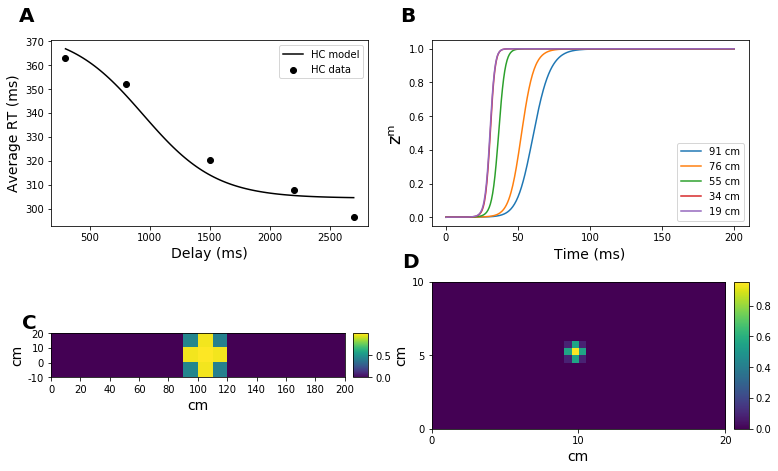

In [14]:
t1 = np.linspace(38, 112, 100)

idx = [0,5,12,19,24]
xf = np.take(RTs,idx)
yf = np.mean(HC_RT,axis=0)

m = (xf.size * np.sum(xf*yf) - np.sum(xf) * np.sum(yf)) / (xf.size*np.sum(xf*xf) - np.sum(xf) ** 2)
bias = (np.sum(yf) - m*np.sum(xf)) / xf.size

evdis = 2

fig, axs = plt.subplots(2, 2, figsize=(12.5, 7.5));

ax1 = plt.subplot(224)
im1 = ax1.imshow(np.mean(ZTs,axis=3)[:,:,evdis].transpose())
ax1.set_ylabel('cm',size=14)
ax1.set_xlabel('cm',size=14)
ax1.set_xticks(np.arange(-.5, 41, 20))
ax1.set_yticks(np.arange(-.5, 21, 10))
ax1.set_xticklabels(np.arange(0, 30, 10))
ax1.set_yticklabels(np.arange(0, 15, 5)[::-1])
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = fig.colorbar(im1,cax=cax)
ax1.text(-0.1, 1.1, string.ascii_uppercase[3], transform=ax1.transAxes, 
            size=20, weight='bold')

ax2 = plt.subplot(223)
im2 = ax2.imshow(np.mean(ZAs,axis=3)[:,:,evdis].transpose())
ax2.set_ylabel('cm',size=14)
ax2.set_xlabel('cm',size=14)
ax2.set_xticks(np.arange(-.5, 21, 2))
ax2.set_yticks(np.arange(-.5, 3, 1))
ax2.set_xticklabels(np.arange(0, 210, 20))
ax2.set_yticklabels(np.arange(-10, 21, 10)[::-1])
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = fig.colorbar(im2,cax=cax)
ax2.text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax2.transAxes, 
            size=20, weight='bold')

ax3 = plt.subplot(222)
x = np.asarray([0,50,100,150,200])
expdistances = np.take(a_distances,idx)
for i in range(len(expdistances)):
    ax3.plot(ZMs[idx[i],:,0],label=str(int(expdistances[i]-20))+" cm")
ax3.set_xlabel('Time (ms)',size=14)
ax3.set_ylabel('z\u1d50',size=18) # change for superscript m
ax3.set_xticks(x/0.4);
ax3.set_xticklabels(x);
plt.legend(loc="lower right",fontsize = 'medium')
ax3.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax3.transAxes, 
            size=20, weight='bold')

ax4 = plt.subplot(221)
ax4.set_xlabel('Delay (ms)',size=14)
ax4.set_ylabel('Average RT (ms)',size=14)
exptimes = np.asarray([300,800,1500,2200,2700])
times1 = np.linspace(300, 2700, 100)
ax4.scatter(exptimes,yf, color = 'black', label = 'HC data')
ax4.plot(np.flip(times1), m*RTsig(t1,etamin,etamax,dc,h)+bias, color = 'black', label='HC model')
ax4.legend(fontsize = 'medium')
ax4.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax4.transAxes, 
            size=20, weight='bold')

fig.savefig('Results/newhcmechanics.png', bbox_inches='tight')


In [15]:
# SCZ model

# Feedforward and feedback synapses. 
Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5) 

# E/I imbalance
b = 4.49317781

# Pruning
prlim = 1.94636878 
PrBa = prun(Ba,prlim)
PrWa = prun(Wa,prlim*2.6)

# Experiment run
sczRTs,sczZMs,sczZTs,sczZAs = experimentrun(trials,a_distances,simtime)


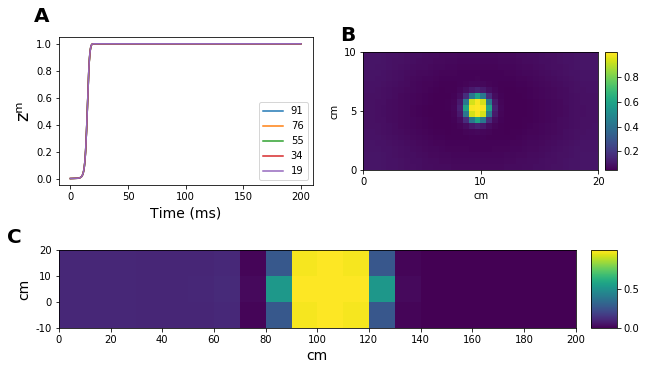

In [16]:
evdis = 2

sczfig, axs = plt.subplots(2, 2, figsize=(10, 6));

ax1 = plt.subplot(222)
im1 = ax1.imshow(np.mean(sczZTs,axis=3)[:,:,evdis].transpose())
ax1.set_ylabel('cm',size=10)
ax1.set_xlabel('cm',size=10)
ax1.set_xticks(np.arange(-.5, 41, 20))
ax1.set_yticks(np.arange(-.5, 21, 10))
ax1.set_xticklabels(np.arange(0, 30, 10))
ax1.set_yticklabels(np.arange(0, 15, 5)[::-1])
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
sczfig.colorbar(im1,cax=cax)
ax1.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax1.transAxes, 
            size=20, weight='bold')

ax2 = plt.subplot(212)
im2 = ax2.imshow(np.mean(sczZAs,axis=3)[:,:,evdis].transpose())
ax2.set_ylabel('cm',size=14)
ax2.set_xlabel('cm',size=14)
ax2.set_xticks(np.arange(-.5, 21, 2))
ax2.set_yticks(np.arange(-.5, 3, 1))
ax2.set_xticklabels(np.arange(0, 210, 20))
ax2.set_yticklabels(np.arange(-10, 21, 10)[::-1])
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
sczfig.colorbar(im2,cax=cax)
ax2.text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax2.transAxes, 
            size=20, weight='bold')

ax3 = plt.subplot(221)
x = np.asarray([0,50,100,150,200])
expdistances = np.take(a_distances,idx)
for i in range(len(expdistances)):
    ax3.plot(sczZMs[i,:,0],label=str(int(expdistances[i]-20)))
ax3.set_xlabel('Time (ms)',size=14)
ax3.set_ylabel('z\u1d50',size=18) # change for superscript m
ax3.set_xticks(x/0.4);
ax3.set_xticklabels(x);
plt.legend(loc="lower right")
ax1.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax3.transAxes, 
            size=20, weight='bold')


sczfig.savefig('Results/sczmechanics.png', bbox_inches='tight')

In [57]:
# H-SPQ model

# Feedforward and feedback synapses. 
Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5) 

# E/I imbalance
b = 4.30153794

# Pruning
prlim = 0.14795582 
PrBa = prun(Ba,prlim)
PrWa = prun(Wa,prlim*2.6)

# Experiment run
spqRTs,spqZMs,spqZTs,spqZAs = experimentrun(trials,a_distances,simtime)


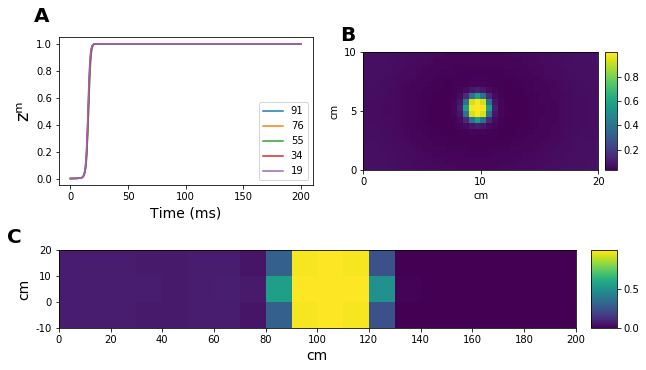

In [92]:
evdis = 2

spqfig, axs = plt.subplots(2, 2, figsize=(10, 6));

ax1 = plt.subplot(222)
im1 = ax1.imshow(np.mean(spqZTs,axis=3)[:,:,evdis].transpose())
ax1.set_ylabel('cm',size=10)
ax1.set_xlabel('cm',size=10)
ax1.set_xticks(np.arange(-.5, 41, 20))
ax1.set_yticks(np.arange(-.5, 21, 10))
ax1.set_xticklabels(np.arange(0, 30, 10))
ax1.set_yticklabels(np.arange(0, 15, 5)[::-1])
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
spqfig.colorbar(im1,cax=cax)
ax1.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax1.transAxes, 
            size=20, weight='bold')

ax2 = plt.subplot(212)
im2 = ax2.imshow(np.mean(spqZAs,axis=3)[:,:,evdis].transpose())
ax2.set_ylabel('cm',size=14)
ax2.set_xlabel('cm',size=14)
ax2.set_xticks(np.arange(-.5, 21, 2))
ax2.set_yticks(np.arange(-.5, 3, 1))
ax2.set_xticklabels(np.arange(0, 210, 20))
ax2.set_yticklabels(np.arange(-10, 21, 10)[::-1])
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
spqfig.colorbar(im2,cax=cax)
ax2.text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax2.transAxes, 
            size=20, weight='bold')

ax3 = plt.subplot(221)
x = np.asarray([0,50,100,150,200])
expdistances = np.take(a_distances,idx)
for i in range(len(expdistances)):
    ax3.plot(spqZMs[i,:,0],label=str(int(expdistances[i]-20)))
ax3.set_xlabel('Time (ms)',size=14)
ax3.set_ylabel('z\u1d50',size=18) # change for superscript m
ax3.set_xticks(x/0.4);
ax3.set_xticklabels(x);
plt.legend(loc="lower right")
ax3.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax3.transAxes, 
            size=20, weight='bold')

#fig.subplots_adjust(wspace=.75)

spqfig.savefig('Results/spqmechanics.png', bbox_inches='tight')

In [81]:
## Pruning parameter sweep
trials = 1

slopes = []
slopesvar = []
centralpoints = []
centralpointsvar = []
pruninglevels = []
mact = []

prlvls = np.asarray([0,0.5,0.75,1.25,2])
Lt,La = Lw(0.15,0.05,1,4,0.15,0.05,20,80) # Define recurrent weights ex,in,sigex,sigin
b = 0 # E/I imbalance

for p in prlvls:
    RTs = np.zeros((trials,len(a_distances)))
    Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5) # Define ff and fb weights
    # Pruning
    prlim = p
    PrBa = prun(Ba,prlim)
    PrWa = prun(Wa,prlim*2.6)
    
    RTs,ZMs,ZTs,ZAs = experimentrun(trials,a_distances,simtime)
    etamin,etamax,dc,h = sigfit(RTs,a_distances)

    slopes.append(np.mean(h))
    slopesvar.append(np.std(1/np.asarray(h)))
    centralpoints.append(np.mean(dc))
    centralpointsvar.append(np.std(dc))
    pruninglevels.append(PrBa)
    mact.append(np.mean(ZMs,axis=2)[2,:])
    

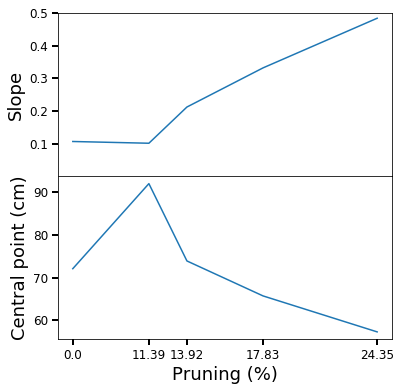

In [111]:
x = np.around(np.asarray(pruninglevels)*100,decimals=2)
x = np.around(100-x,decimals=2)

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(6,6))

#ax1 = plt.subplot()
ax1.plot(prlvls,1/np.asarray(slopes),label = "Model")
ax1.set_ylabel('Slope',size=18)
ax1.set_ylim(0,0.5)
ax1.set_yticks([0.10,0.20,0.30,0.40,0.50])
ax1.tick_params(length=6, width=2,labelsize = 'large') 

ax2.plot(prlvls,np.asarray(centralpoints)-20,label="Model")
ax2.set_xlabel('Pruning (%)',size=18)
ax2.set_ylabel('Central point (cm)',size=18)
ax2.set_xticks(prlvls)
ax2.set_xticklabels(x)
ax2.tick_params(length=6, width=2,labelsize = 'large')

plt.subplots_adjust(hspace=.0)
plt.savefig('Results/pruning.png', bbox_inches='tight')

In [69]:
## E/I imbalance parameter sweep - disinhibition

trials = 1

slopes = []
slopesvar = []
centralpoints = []
centralpointsvar = []
imbalances = np.arange(0,5,0.5) # -1.25 to 4.5 is the working range

mact = []

Lt,La = Lw(0.15,0.05,1,4,0.15,0.05,20,80) # Define recurrent weights ex,in,sigex,sigin
Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5) # Define ff and fb weights

for bi in imbalances:
    RTs = np.zeros((trials,len(a_distances)))
    
    # E/I imbalance
    b = bi
    
    RTs,ZMs,ZTs,ZAs = experimentrun(trials,a_distances,simtime)
    etamin,etamax,dc,h = sigfit(RTs,a_distances)

    slopes.append(np.mean(h))
    slopesvar.append(np.std(1/np.asarray(h)))
    centralpoints.append(np.mean(dc))
    centralpointsvar.append(np.std(dc))
    mact.append(np.mean(ZMs,axis=2)[2,:])


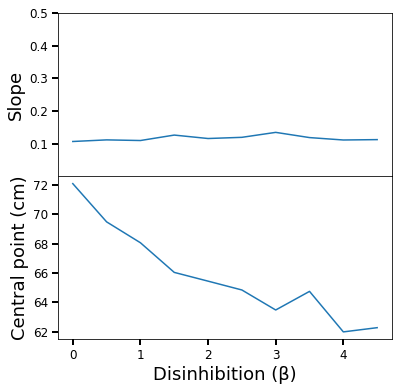

In [116]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(6,6))

ax1.plot(imbalances,1/np.asarray(slopes),label = "Model")
#ax1.plot(imbalances,np.repeat(0.23,len(imbalances)),color='red',linestyle=':',label = "SCZ")
#ax1.plot(imbalances,np.repeat(0.09,len(imbalances)),color='black',linestyle=':', label = "HC")
ax1.set_ylabel('Slope',size=18)
ax1.set_yticks([0.10,0.20,0.30,0.40,0.50])
ax1.tick_params(length=6, width=2,labelsize = 'large') 
ax1.set_ylim(0,0.5)

ax2.plot(imbalances,np.asarray(centralpoints)-20,label="Model")
#ax2.plot(imbalances,np.repeat(72.10-9.75,len(imbalances)),color='red',linestyle=':',label = "SCZ")
#ax2.plot(imbalances,np.repeat(72.10,len(imbalances)),color='black',linestyle=':', label = "HC")
#ax2.plot(imbalances,np.repeat(72.10-6.39,len(imbalances)),color='green',linestyle=':', label = "H-SPQ")
ax2.set_xlabel('Disinhibition (\u03B2)',size=18)
ax2.set_ylabel('Central point (cm)',size=18)
ax2.tick_params(length=6, width=2,labelsize = 'large') 
#ax2.legend(loc="center right",bbox_to_anchor=(1.26,1),fontsize = 'xx-large')
plt.subplots_adjust(hspace=.0)
plt.savefig('Results/posimbalance.png', bbox_inches='tight')


In [112]:
## E/I imbalance parameter sweep - Reduce excitation
# D2 fail is implemented as bias in neurons firings, assuming that only affects inhibition. 
trials = 1

slopes = []
slopesvar = []
centralpoints = []
centralpointsvar = []
imbalances = np.arange(-1.25,0.125,0.125) # -1.25 to 4.5 is the working range

mact = []

Lt,La = Lw(0.15,0.05,1,4,0.15,0.05,20,80) # Define recurrent weights ex,in,sigex,sigin
Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5) # Define ff and fb weights

for bi in imbalances:
    RTs = np.zeros((trials,len(a_distances)))
    
    # E/I imbalance
    b = bi
    
    RTs,ZMs,ZTs,ZAs = experimentrun(trials,a_distances,simtime)
    etamin,etamax,dc,h = sigfit(RTs,a_distances)

    slopes.append(np.mean(h))
    slopesvar.append(np.std(1/np.asarray(h)))
    centralpoints.append(np.mean(dc))
    centralpointsvar.append(np.std(dc))
    mact.append(np.mean(ZMs,axis=2)[2,:])


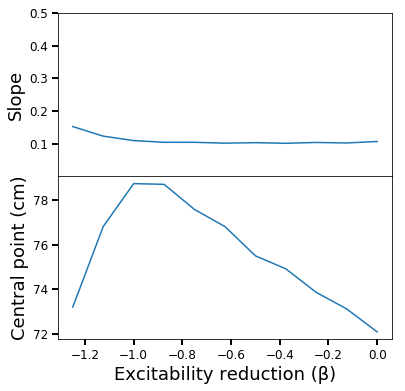

In [29]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(6,6))

ax1.plot(imbalances,1/np.asarray(slopes),label = "Model")
ax1.set_ylabel('Slope',size=18)
ax1.set_ylim(0,0.5)
ax1.set_yticks([0.10,0.20,0.30,0.40,0.50])
ax1.tick_params(length=6, width=2,labelsize = 'large')

ax2.plot(imbalances,np.asarray(centralpoints)-20,label="Model")
ax2.set_xlabel('Excitability reduction (\u03B2)',size=18)
ax2.set_ylabel('Central point (cm)',size=18)
ax2.tick_params(length=6, width=2,labelsize = 'large') 

plt.subplots_adjust(hspace=.0)
plt.savefig('Results/negimbalance.png', bbox_inches='tight')


In [55]:
## Interaction of Pruning and E/I imbalance
trials = 1
imbalances = np.arange(0,5,0.5) # -1.25 to 4.5 is the working range
prlvls = np.asarray([0,0.5,0.75,1.25,2])

slopes = np.zeros((len(prlvls),len(imbalances)))
slopesvar = np.zeros((len(prlvls),len(imbalances)))
centralpoints = np.zeros((len(prlvls),len(imbalances)))
centralpointsvar = np.zeros((len(prlvls),len(imbalances)))

Lt,La = Lw(0.15,0.05,1,4,0.15,0.05,20,80) # Define recurrent weights ex,in,sigex,sigin

for p in range(len(prlvls)):
    for bi in range(len(imbalances)):
        Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5) # Define ff and fb weights
        RTs = np.zeros((trials,len(a_distances)))

        # E/I imbalance
        b = imbalances[bi]
        
        # Pruning
        prlim = prlvls[p]
        PrBa = prun(Ba,prlim)
        PrWa = prun(Wa,prlim*2.6)

        RTs,ZMs,ZTs,ZAs = experimentrun(trials,a_distances,simtime)
        etamin,etamax,dc,h = sigfit(RTs,a_distances)

        slopes[p,bi] = np.mean(1/np.asarray(h))
        slopesvar[p,bi] = np.std(1/np.asarray(h))
        centralpoints[p,bi] = np.mean(dc)
        centralpointsvar[p,bi] = np.std(dc)


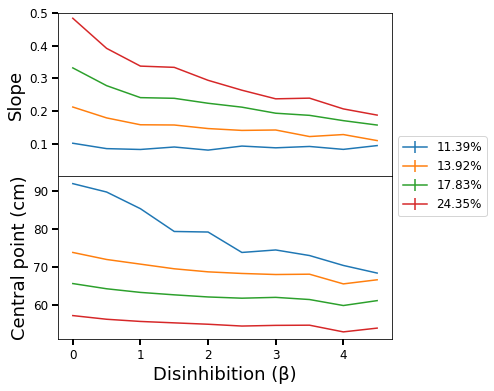

In [117]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(6,6))

for i in [1,2,3,4]:
    ax1.errorbar(imbalances,slopes[i,:],yerr = slopesvar[i,:]/np.sqrt(trials),label = str(x[i])+"%")
ax1.set_ylabel("Slope",size=18)
ax1.set_ylim(0,0.5)
ax1.set_yticks([0.10,0.20,0.30,0.40,0.50])
ax1.tick_params(length=6, width=2,labelsize = 'large')

for i in [1,2,3,4]:
    ax2.errorbar(imbalances,centralpoints[i,:]-20,yerr = centralpointsvar[i,:]/np.sqrt(trials),label=str(x[i])+"%")    
ax2.set_xlabel('Disinhibition (\u03B2)',size=18)
ax2.set_ylabel('Central point (cm)',size=18)
ax2.tick_params(length=6, width=2,labelsize = 'large') 
ax2.legend(loc="center right",bbox_to_anchor=(1.3,1),fontsize = 'large')

plt.subplots_adjust(hspace=.0)
plt.savefig('Results/interaction.png', bbox_inches='tight')

In [ ]:
trials = 1
imbalances = np.arange(-1.25,0.125,0.125)
prlvls = np.asarray([0,0.25,0.5,1.5,2.5])

slopes = np.zeros((len(prlvls),len(imbalances)))
slopesvar = np.zeros((len(prlvls),len(imbalances)))
centralpoints = np.zeros((len(prlvls),len(imbalances)))
centralpointsvar = np.zeros((len(prlvls),len(imbalances)))

#mact = []
Lt,La = Lw(0.15,0.05,1,4,0.15,0.05,20,80) # Define recurrent weights ex,in,sigex,sigin

for p in range(len(prlvls)):
    for bi in range(len(imbalances)):
        Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5) # Define ff and fb weights
        RTs = np.zeros((trials,len(a_distances)))

        # E/I imbalance
        b = imbalances[bi]
        
        # Pruning
        prlim = prlvls[p]
        PrBa = prun(Ba,prlim)
        PrWa = prun(Wa,prlim*2.6)

        RTs,ZMs,ZTs,ZAs = experimentrun(trials,a_distances,simtime)
        etamin,etamax,dc,h = sigfit(RTs,a_distances)

        slopes[p,bi] = np.mean(h)
        slopesvar[p,bi] = np.std(1/np.asarray(h))
        centralpoints[p,bi] = np.mean(dc)
        centralpointsvar[p,bi] = np.std(dc)
        
## Errors reported are due to failures in fitting the data to a sigmoid function.
## The model only generates a sigmoid like shape within a range of parameters.

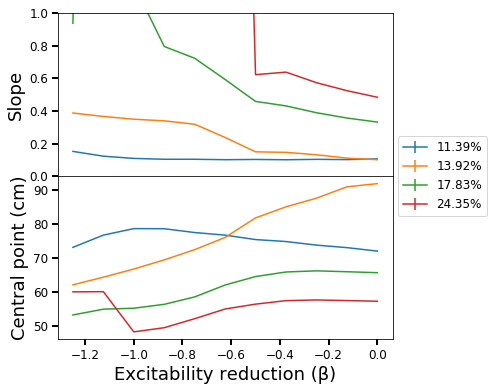

In [27]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(6,6))

ax1.set_ylabel("Slope",size=18)
ax1.set_ylim(0,1)
for i in [1,2,3,4]:
    ax1.errorbar(imbalances,1/slopes[i,:],yerr = slopesvar[i,:]/np.sqrt(trials),label = str(x[i])+"%")
ax1.tick_params(length=6, width=2,labelsize = 'large')    

ax2.set_ylabel('Central point (cm)',size=18)
for i in [1,2,3,4]:
    ax2.errorbar(imbalances,centralpoints[i,:]-20,yerr = centralpointsvar[i,:]/np.sqrt(trials),label=str(x[i])+"%")
ax2.legend(loc="center right",bbox_to_anchor=(1.3,1),fontsize = 'large')
ax2.set_xlabel('Excitability reduction (\u03B2)',size=18)
ax2.tick_params(length=6, width=2,labelsize = 'large')

plt.subplots_adjust(hspace=.0)

plt.savefig('Results/neginteraction.png', bbox_inches='tight')